In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
import pyross
import pandas as pd
import time 
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [3]:
## population and age classes
M=4  ## number of age classes

my_data = np.genfromtxt('../data/age_structures/UK.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

Ni0=aM+aF;   Ni=np.zeros((M))

# scale the population down to a more manageble level 
Ni[0] = (np.sum(Ni0[0:4])).astype('int')
Ni[1] = (np.sum(Ni0[4:8])).astype('int')
Ni[2] = (np.sum(Ni0[8:12])).astype('int')
Ni[3] = (np.sum(Ni0[12:16])).astype('int')
N=np.sum(Ni)
print(N)
fi = Ni/N 

64111602.0


In [4]:
# Get individual contact matrices
CH0, CW0, CS0, CO0 = pyross.contactMatrix.UK()


CH = np.zeros((M, M))
CW = np.zeros((M, M))
CS = np.zeros((M, M))
CO = np.zeros((M, M))

for i in range(16):
    CH0[i,:] = CH0[i,:]*Ni0[i]
    CW0[i,:] = CW0[i,:]*Ni0[i]
    CS0[i,:] = CS0[i,:]*Ni0[i]
    CO0[i,:] = CO0[i,:]*Ni0[i]


for i in range(M):
    for j in range(M):
        i1, j1 = i*4, j*4
        CH[i,j] = np.sum( CH0[i1:i1+4, j1:j1+4] )/Ni[i]
        CW[i,j] = np.sum( CW0[i1:i1+4, j1:j1+4] )/Ni[i]
        CS[i,j] = np.sum( CS0[i1:i1+4, j1:j1+4] )/Ni[i]
        CO[i,j] = np.sum( CO0[i1:i1+4, j1:j1+4] )/Ni[i]
        
N = N/5e2
Ni = Ni/5e2

In [5]:
# Generate class with contact matrix for SIR-type model with UK contact structure
generator = pyross.contactMatrix.SIR(CH, CW, CS, CO)

times= [20] # temporal boundaries between different contact-behaviour

aW, aS, aO = 0.4, 0.4, 0.4

# prefactors for CW, CS, CO:
interventions = [[1.0,1.0,1.0],      # before first time
                 [aW, aS, aO],       # after first time
                ]         

# generate corresponding contact matrix function
C = generator.interventions_temporal(times=times,interventions=interventions)

In [6]:
beta  = 0.04         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1./7            
gIh   = 1/14
gIc   = 1/14
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter
fh = 0.1 
gE    = 1/5
gA    = 1/3

hh   = 0.1*np.ones(M)       # fraction which goes from Is to hospital
cc   = 0.05*np.ones(M)      # fraction which goes from  hospital to ICU 
mm   = 0.4*np.ones(M)       # mortality from IC
sa = 0  # change in the population, not taken into account by inference at the moment 


# initial conditions
E0   = np.array([10]*M)
A0   = np.array([10]*M)
Ia0  = np.array([10]*M)# each age group has asymptomatic infectives
Is0  = np.array([10]*M)# and also symptomatic infectives
Ih0  = np.array([10]*M)
Ic0  = np.array([10]*M)
Im0  = np.array([2]*M)
R0   = np.zeros(M)
S0   = Ni - (Ia0+Is0+R0+E0+A0+Ih0+Ic0+Im0)

parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,
              'gIh':gIh,'gIc':gIc,  'gE':gE, 'gA':gA,
              'fsa':fsa, 'fh':fh, 
              'sa':sa, 'hh':hh, 'cc':cc, 'mm':mm}
model = pyross.stochastic.SEAI5R(parameters, M, Ni)
print(Ni)

#def contactMatrix(t):
#    if t < 20:
#        return CH + CS + CW + CO
#    else:
#        return CH + aS*CS + aW*CW + aO*CO


# start simulation
Tf=100;  Nf=Tf+1 
# data=model.simulate(S0, E0, A0, Ia0, Is0, Ih0, Ic0, Im0, C, Tf, Nf)

[31268.886 35668.366 35526.088 25759.864]


In [7]:
## Save pre intervention traj
Tf = 20 
Nf = Tf+1
#np.save('pre_intervention_traj_SEAI5R.npy', data['X'][:Nf,:])

# plot the stochastic solution 
plt.plot(data['X'][:, M], label='E')
plt.plot(data['X'][:, 2*M], label='A')
plt.plot(data['X'][:, 3*M], label='Ia')
plt.plot(data['X'][:, 4*M], label='Is')
plt.plot(data['X'][:, 5*M], label='Ih')
plt.plot(data['X'][:, 6*M], label='Ic')
plt.plot(data['X'][:, 7*M], label='Im')
plt.legend()
plt.show()

NameError: name 'data' is not defined

-6284.001296771972
9.360590934753418


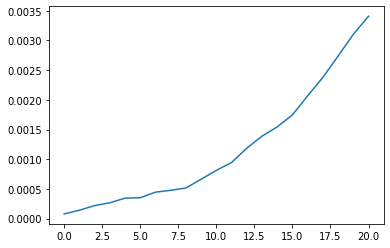

In [10]:
Tf = 20 # truncate to only getting the first few datapoints 
Nf = Tf+1

x = np.load('pre_intervention_traj_SEAI5R.npy')
x = (x/N)[:Nf,:8*M]
steps = 101 # number internal integration steps taken, must be an odd number 


# initialise the estimator 
estimator = pyross.inference.SEAI5R(parameters, M, fi, int(N), steps)

# compute -log_p for the original (correct) parameters 
start_time = time.time() 
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, generator.constant_CM)
end_time = time.time()
print(logp) 
print(end_time - start_time)

plt.plot(x[:, M])
plt.show()

In [11]:
#### infer the parameters from the initial part of the trajectory

# initialise the estimator 
estimator = pyross.inference.SEAI5R(parameters, M, fi, int(N), steps)

## create filter to distinguish between observable classes
obs=x[:Nf] ## up to intervention time

## guesses for params

alpha_g = 0.3          ## bad initial guess
alpha_std = 0.2 
alpha_b = (0.1,0.5)

beta_g  = 0.03         ## bad initial guess
beta_std = 0.1 
beta_b = (1e-3, 1)

gIa_g   = 0.15  
gIa_std = 0.05 
gIa_b = (0.01, 1)

gIs_g   = 0.13 
gIs_std = 0.05 
gIs_b = (0.01, 1)

gE_g    = 0.2
gE_std = 0.05 
gE_b = (0.01, 1)

gA_g    = 0.3 
gA_std = 0.1 
gA_b = (0.01, 1) 

# optimisation parameters 
eps = 1e-4 # step used to calculate hessian in the optimisation algorithm 
ftol = 1e-5 # the relative tol in (-logp)  

# the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 
bounds = np.array([alpha_b, beta_b, gIa_b, gIs_b, gE_b, gA_b])#, *bounds_for_S, *bounds_for_E, *bounds_for_A, *bounds_for_Ia, *bounds_for_Is, *bounds_for_Ih, *bounds_for_Ic, *bounds_for_Im])
# stds of the model parameters' priors
stds = np.array([alpha_std, beta_std, gIa_std, gIs_std, gE_std, gA_std])

# make an initial guess and do inference 
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, gE_g, gA_g])#, *S0_g, *E0_g, *A0_g, *Ia0_g, *Is0_g, *Ih0_g, *Ic0_g, *Im0_g])
params = estimator.inference(guess, stds, obs, Tf, Nf, generator.constant_CM, 
                                  bounds=bounds, verbose=True, 
                                   global_max_iter=15, global_ftol_factor=1e3, 
                                    ftol=ftol, eps=eps) 
# the L-BFGS-B method prints to the terminal rather than here 

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 6 (seed=370183, Fri May  1 09:22:39 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -6.244994618837658e+03 1.0e+00 1.03e+00  2e-02  6e-02 1:24.8
    2     32 -6.252362566874744e+03 1.4e+00 1.17e+00  2e-02  8e-02 2:57.0
    3     48 -6.218628162801626e+03 1.8e+00 1.29e+00  2e-02  9e-02 4:29.1
    4     64 -6.083865990607695e+03 2.3e+00 1.19e+00  2e-02  8e-02 6:03.3
    5     80 -6.211372186299429e+03 2.5e+00 1.05e+00  2e-02  7e-02 7:40.1
    6     96 -6.250609182983373e+03 3.0e+00 1.03e+00  1e-02  7e-02 9:14.2
    7    112 -6.271262777934268e+03 3.8e+00 8.64e-01  1e-02  6e-02 10:45.1
    8    128 -6.275941538891155e+03 4.1e+00 9.33e-01  1e-02  7e-02 12:16.3
    9    144 -6.279498050499621e+03 4.9e+00 9.04e-01  9e-03  7e-02 13:51.1
   10    160 -6.274557234477785e+03 6.1e+00 9.46e-01  8e-03  7e-02 15:22.1
   11    176 -6.285806387411659e+03 7.8e+00 8.75e-01  7e-03  

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
  File "pyross/inference.pyx", line 547, in pyross.inference.SIR_type.estimate_cond_mean_cov
Traceback (most recent call last):
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py", line 245, in odeint
    int(bool(tfirst)))
  File "pyross/inference.pyx", line 540, in pyross.inference.SIR_type.estimate_cond_mean_cov.rhs
  File "pyross/contactMatrix.pyx", line 167, in pyross.contactMatrix.SIR.interventions_temporal.C_func
  File "<__array_function__ internals>", line 2, in argmin
  File "pyross/inference.pyx", line 547, in pyross.inference.SIR_type.estimate_cond_mean_cov
KeyboardInterrupt
Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py", line 245, in odein

LinAlgError: SVD did not converge in Linear Least Squares

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 538, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/chebyshev.py", line 1647, in chebfit
    return pu._fit(chebvander, x, y, deg, rcond, full, w)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/polyutils.py", line 710, in _fit
    c, resids, rank, s = np.linalg.lstsq(lhs.T/scl, rhs.T, rcond)
  File "<__array_function__ internals>", line 6, in lstsq
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 2259, in lstsq
    x, resids, rank, s = gufunc(a, b, rcond, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 109, in _raise_linalgerror_lstsq
    raise LinAlgError("SVD did not converge in Linear Least S

LinAlgError: SVD did not converge in Linear Least Squares

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 538, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/chebyshev.py", line 1647, in chebfit
    return pu._fit(chebvander, x, y, deg, rcond, full, w)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/polyutils.py", line 710, in _fit
    c, resids, rank, s = np.linalg.lstsq(lhs.T/scl, rhs.T, rcond)
  File "<__array_function__ internals>", line 6, in lstsq
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 2259, in lstsq
    x, resids, rank, s = gufunc(a, b, rcond, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 109, in _raise_linalgerror_lstsq
    raise LinAlgError("SVD did not converge in Linear Least S

LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):


LinAlgError: Singular matrix

  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
Traceback (most recent call last):
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    raise LinAlgError("Singular matrix")
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlg

LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")


LinAlgError: Singular matrix

numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


LinAlgError: SVD did not converge in Linear Least Squares

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 538, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/chebyshev.py", line 1647, in chebfit
    return pu._fit(chebvander, x, y, deg, rcond, full, w)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/polyutils.py", line 710, in _fit
    c, resids, rank, s = np.linalg.lstsq(lhs.T/scl, rhs.T, rcond)
  File "<__array_function__ internals>", line 6, in lstsq
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 2259, in lstsq
    x, resids, rank, s = gufunc(a, b, rcond, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 109, in _raise_linalgerror_lstsq
    raise LinAlgError("SVD did not converge in Linear Least S

LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


LinAlgError: SVD did not converge in Linear Least Squares

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 538, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/chebyshev.py", line 1647, in chebfit
    return pu._fit(chebvander, x, y, deg, rcond, full, w)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/polyutils.py", line 710, in _fit
    c, resids, rank, s = np.linalg.lstsq(lhs.T/scl, rhs.T, rcond)
  File "<__array_function__ internals>", line 6, in lstsq
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 2259, in lstsq
    x, resids, rank, s = gufunc(a, b, rcond, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 109, in _raise_linalgerror_lstsq
    raise LinAlgError("SVD did not converge in Linear Least S

LinAlgError: SVD did not converge in Linear Least Squares

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 538, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/chebyshev.py", line 1647, in chebfit
    return pu._fit(chebvander, x, y, deg, rcond, full, w)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/polyutils.py", line 710, in _fit
    c, resids, rank, s = np.linalg.lstsq(lhs.T/scl, rhs.T, rcond)
  File "<__array_function__ internals>", line 6, in lstsq
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 2259, in lstsq
    x, resids, rank, s = gufunc(a, b, rcond, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 109, in _raise_linalgerror_lstsq
    raise LinAlgError("SVD did not converge in Linear Least S

LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


LinAlgError: SVD did not converge in Linear Least Squares

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 538, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/chebyshev.py", line 1647, in chebfit
    return pu._fit(chebvander, x, y, deg, rcond, full, w)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/polyutils.py", line 710, in _fit
    c, resids, rank, s = np.linalg.lstsq(lhs.T/scl, rhs.T, rcond)
  File "<__array_function__ internals>", line 6, in lstsq
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 2259, in lstsq
    x, resids, rank, s = gufunc(a, b, rcond, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 109, in _raise_linalgerror_lstsq
    raise LinAlgError("SVD did not converge in Linear Least S

LinAlgError: SVD did not converge in Linear Least Squares

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 538, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/chebyshev.py", line 1647, in chebfit
    return pu._fit(chebvander, x, y, deg, rcond, full, w)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/polyutils.py", line 710, in _fit
    c, resids, rank, s = np.linalg.lstsq(lhs.T/scl, rhs.T, rcond)
  File "<__array_function__ internals>", line 6, in lstsq
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 2259, in lstsq
    x, resids, rank, s = gufunc(a, b, rcond, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 109, in _raise_linalgerror_lstsq
    raise LinAlgError("SVD did not converge in Linear Least S

LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: SVD did not converge in Linear Least Squares

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 538, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/chebyshev.py", line 1647, in chebfit
    return pu._fit(chebvander, x, y, deg, rcond, full, w)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/polyutils.py", line 710, in _fit
    c, resids, rank, s = np.linalg.lstsq(lhs.T/scl, rhs.T, rcond)
  File "<__array_function__ internals>", line 6, in lstsq
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 2259, in lstsq
    x, resids, rank, s = gufunc(a, b, rcond, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 109, in _raise_linalgerror_lstsq
    raise LinAlgError("SVD did not converge in Linear Least S

LinAlgError: SVD did not converge in Linear Least Squares

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 538, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/chebyshev.py", line 1647, in chebfit
    return pu._fit(chebvander, x, y, deg, rcond, full, w)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/polyutils.py", line 710, in _fit
    c, resids, rank, s = np.linalg.lstsq(lhs.T/scl, rhs.T, rcond)
  File "<__array_function__ internals>", line 6, in lstsq
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 2259, in lstsq
    x, resids, rank, s = gufunc(a, b, rcond, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 109, in _raise_linalgerror_lstsq
    raise LinAlgError("SVD did not converge in Linear Least S

LinAlgError: SVD did not converge in Linear Least Squares

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 538, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/chebyshev.py", line 1647, in chebfit
    return pu._fit(chebvander, x, y, deg, rcond, full, w)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/polyutils.py", line 710, in _fit
    c, resids, rank, s = np.linalg.lstsq(lhs.T/scl, rhs.T, rcond)
  File "<__array_function__ internals>", line 6, in lstsq
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 2259, in lstsq
    x, resids, rank, s = gufunc(a, b, rcond, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 109, in _raise_linalgerror_lstsq
    raise LinAlgError("SVD did not converge in Linear Least S

LinAlgError: SVD did not converge in Linear Least Squares

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 538, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/chebyshev.py", line 1647, in chebfit
    return pu._fit(chebvander, x, y, deg, rcond, full, w)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/polyutils.py", line 710, in _fit
    c, resids, rank, s = np.linalg.lstsq(lhs.T/scl, rhs.T, rcond)
  File "<__array_function__ internals>", line 6, in lstsq
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 2259, in lstsq
    x, resids, rank, s = gufunc(a, b, rcond, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 109, in _raise_linalgerror_lstsq
    raise LinAlgError("SVD did not converge in Linear Least S

LinAlgError: SVD did not converge in Linear Least Squares

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 538, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/chebyshev.py", line 1647, in chebfit
    return pu._fit(chebvander, x, y, deg, rcond, full, w)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/polyutils.py", line 710, in _fit
    c, resids, rank, s = np.linalg.lstsq(lhs.T/scl, rhs.T, rcond)
  File "<__array_function__ internals>", line 6, in lstsq
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 2259, in lstsq
    x, resids, rank, s = gufunc(a, b, rcond, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 109, in _raise_linalgerror_lstsq
    raise LinAlgError("SVD did not converge in Linear Least S

LinAlgError: SVD did not converge in Linear Least Squares

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 538, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/chebyshev.py", line 1647, in chebfit
    return pu._fit(chebvander, x, y, deg, rcond, full, w)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/polyutils.py", line 710, in _fit
    c, resids, rank, s = np.linalg.lstsq(lhs.T/scl, rhs.T, rcond)
  File "<__array_function__ internals>", line 6, in lstsq
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 2259, in lstsq
    x, resids, rank, s = gufunc(a, b, rcond, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 109, in _raise_linalgerror_lstsq
    raise LinAlgError("SVD did not converge in Linear Least S

LinAlgError: SVD did not converge in Linear Least Squares

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 538, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/chebyshev.py", line 1647, in chebfit
    return pu._fit(chebvander, x, y, deg, rcond, full, w)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/polyutils.py", line 710, in _fit
    c, resids, rank, s = np.linalg.lstsq(lhs.T/scl, rhs.T, rcond)
  File "<__array_function__ internals>", line 6, in lstsq
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 2259, in lstsq
    x, resids, rank, s = gufunc(a, b, rcond, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 109, in _raise_linalgerror_lstsq
    raise LinAlgError("SVD did not converge in Linear Least S

LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: SVD did not converge in Linear Least Squares

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 538, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/chebyshev.py", line 1647, in chebfit
    return pu._fit(chebvander, x, y, deg, rcond, full, w)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/polyutils.py", line 710, in _fit
    c, resids, rank, s = np.linalg.lstsq(lhs.T/scl, rhs.T, rcond)
  File "<__array_function__ internals>", line 6, in lstsq
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 2259, in lstsq
    x, resids, rank, s = gufunc(a, b, rcond, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 109, in _raise_linalgerror_lstsq
    raise LinAlgError("SVD did not converge in Linear Least S

LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: SVD did not converge in Linear Least Squares

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 538, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/chebyshev.py", line 1647, in chebfit
    return pu._fit(chebvander, x, y, deg, rcond, full, w)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/polyutils.py", line 710, in _fit
    c, resids, rank, s = np.linalg.lstsq(lhs.T/scl, rhs.T, rcond)
  File "<__array_function__ internals>", line 6, in lstsq
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 2259, in lstsq
    x, resids, rank, s = gufunc(a, b, rcond, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 109, in _raise_linalgerror_lstsq
    raise LinAlgError("SVD did not converge in Linear Least S

LinAlgError: SVD did not converge in Linear Least Squares

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 538, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/chebyshev.py", line 1647, in chebfit
    return pu._fit(chebvander, x, y, deg, rcond, full, w)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/polyutils.py", line 710, in _fit
    c, resids, rank, s = np.linalg.lstsq(lhs.T/scl, rhs.T, rcond)
  File "<__array_function__ internals>", line 6, in lstsq
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 2259, in lstsq
    x, resids, rank, s = gufunc(a, b, rcond, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 109, in _raise_linalgerror_lstsq
    raise LinAlgError("SVD did not converge in Linear Least S

LinAlgError: SVD did not converge in Linear Least Squares

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 538, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/chebyshev.py", line 1647, in chebfit
    return pu._fit(chebvander, x, y, deg, rcond, full, w)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/polyutils.py", line 710, in _fit
    c, resids, rank, s = np.linalg.lstsq(lhs.T/scl, rhs.T, rcond)
  File "<__array_function__ internals>", line 6, in lstsq
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 2259, in lstsq
    x, resids, rank, s = gufunc(a, b, rcond, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 109, in _raise_linalgerror_lstsq
    raise LinAlgError("SVD did not converge in Linear Least S

LinAlgError: SVD did not converge in Linear Least Squares

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 538, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/chebyshev.py", line 1647, in chebfit
    return pu._fit(chebvander, x, y, deg, rcond, full, w)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/polyutils.py", line 710, in _fit
    c, resids, rank, s = np.linalg.lstsq(lhs.T/scl, rhs.T, rcond)
  File "<__array_function__ internals>", line 6, in lstsq
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 2259, in lstsq
    x, resids, rank, s = gufunc(a, b, rcond, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 109, in _raise_linalgerror_lstsq
    raise LinAlgError("SVD did not converge in Linear Least S

KeyboardInterrupt: 

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 547, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py", line 245, in odeint
    int(bool(tfirst)))
  File "pyross/inference.pyx", line 540, in pyross.inference.SIR_type.estimate_cond_mean_cov.rhs
  File "pyross/contactMatrix.pyx", line 167, in pyross.contactMatrix.SIR.interventions_temporal.C_func
  File "<__array_function__ internals>", line 2, in argmin
KeyboardInterrupt


KeyboardInterrupt: 

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'


KeyboardInterrupt: 

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
Traceback (most recent call last):
  File "pyross/inference.pyx", line 547, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py", line 245, in odeint


KeyboardInterrupt: 

  File "pyross/inference.pyx", line 547, in pyross.inference.SIR_type.estimate_cond_mean_cov
    int(bool(tfirst)))
  File "pyross/inference.pyx", line 541, in pyross.inference.SIR_type.estimate_cond_mean_cov.rhs
Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
  File "pyross/inference.pyx", line 911, in pyross.inference.SEAI5R.lyapunov_fun
  File "pyross/inference.pyx", line 626, in pyross.inference.SIR_type.flatten_lyaponuv
  File "<__array_function__ internals>", line 6, in kron
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/shape_base.py", line 1155, in kron
    result = concatenate(result, axis=axis)
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in concatenate
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py", line 245, in odeint
KeyboardInterrupt
  File "pyross/inference.pyx", line 547, in pyross.inference.SIR_type.estimate_cond_mean_cov
    int(bo

LinAlgError: SVD did not converge in Linear Least Squares

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 538, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/chebyshev.py", line 1647, in chebfit
    return pu._fit(chebvander, x, y, deg, rcond, full, w)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/polyutils.py", line 710, in _fit
    c, resids, rank, s = np.linalg.lstsq(lhs.T/scl, rhs.T, rcond)
  File "<__array_function__ internals>", line 6, in lstsq
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 2259, in lstsq
    x, resids, rank, s = gufunc(a, b, rcond, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 109, in _raise_linalgerror_lstsq
    raise LinAlgError("SVD did not converge in Linear Least S

LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: SVD did not converge in Linear Least Squares

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 538, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/chebyshev.py", line 1647, in chebfit
    return pu._fit(chebvander, x, y, deg, rcond, full, w)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/polyutils.py", line 710, in _fit
    c, resids, rank, s = np.linalg.lstsq(lhs.T/scl, rhs.T, rcond)
  File "<__array_function__ internals>", line 6, in lstsq
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 2259, in lstsq
    x, resids, rank, s = gufunc(a, b, rcond, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 109, in _raise_linalgerror_lstsq
    raise LinAlgError("SVD did not converge in Linear Least S

LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: SVD did not converge in Linear Least Squares

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 538, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/chebyshev.py", line 1647, in chebfit
    return pu._fit(chebvander, x, y, deg, rcond, full, w)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/polyutils.py", line 710, in _fit
    c, resids, rank, s = np.linalg.lstsq(lhs.T/scl, rhs.T, rcond)
  File "<__array_function__ internals>", line 6, in lstsq
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 2259, in lstsq
    x, resids, rank, s = gufunc(a, b, rcond, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 109, in _raise_linalgerror_lstsq
    raise LinAlgError("SVD did not converge in Linear Least S

LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/chebyshev.py:1154: RuntimeWarning: invalid value encountered in subtract
  c0 = c[-i] - c1
/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/chebyshev.py:1155: RuntimeWarning: invalid value encountered in add
  c1 = tmp + c1*x2
/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py:2057: RuntimeWarning: invalid value encountered i

LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: SVD did not converge in Linear Least Squares

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 538, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/chebyshev.py", line 1647, in chebfit
    return pu._fit(chebvander, x, y, deg, rcond, full, w)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/polyutils.py", line 710, in _fit
    c, resids, rank, s = np.linalg.lstsq(lhs.T/scl, rhs.T, rcond)
  File "<__array_function__ internals>", line 6, in lstsq
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 2259, in lstsq
    x, resids, rank, s = gufunc(a, b, rcond, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 109, in _raise_linalgerror_lstsq
    raise LinAlgError("SVD did not converge in Linear Least S

KeyboardInterrupt: 

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'


KeyboardInterrupt: 

Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
  File "pyross/inference.pyx", line 547, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py", line 245, in odeint
    int(bool(tfirst)))
  File "pyross/inference.pyx", line 541, in pyross.inference.SIR_type.estimate_cond_mean_cov.rhs
  File "pyross/inference.pyx", line 911, in pyross.inference.SEAI5R.lyapunov_fun
  File "pyross/inference.pyx", line 626, in pyross.inference.SIR_type.flatten_lyaponuv
  File "<__array_function__ internals>", line 6, in kron
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/shape_base.py", line 1155, in kron
    result = concatenate(result, axis=axis)
KeyboardInterrupt


KeyboardInterrupt: 

Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'


KeyboardInterrupt: 

  File "pyross/inference.pyx", line 547, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py", line 245, in odeint
Traceback (most recent call last):
    int(bool(tfirst)))
  File "pyross/inference.pyx", line 547, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 541, in pyross.inference.SIR_type.estimate_cond_mean_cov.rhs
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py", line 245, in odeint
  File "pyross/inference.pyx", line 911, in pyross.inference.SEAI5R.lyapunov_fun
    int(bool(tfirst)))
  File "pyross/inference.pyx", line 626, in pyross.inference.SIR_type.flatten_lyaponuv
  File "pyross/inference.pyx", line 541, in pyross.inference.SIR_type.estimate_cond_mean_cov.rhs
  File "<__array_function__ internals>", line 6, in kron
  File "pyross/inference.pyx", line 911, in pyross.inference.SEAI5R.lyapunov_fun
  F

LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in inv
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 547, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: SVD did not converge in Linear Least Squares

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 538, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/chebyshev.py", line 1647, in chebfit
    return pu._fit(chebvander, x, y, deg, rcond, full, w)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/polyutils.py", line 710, in _fit
    c, resids, rank, s = np.linalg.lstsq(lhs.T/scl, rhs.T, rcond)
  File "<__array_function__ internals>", line 6, in lstsq
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 2259, in lstsq
    x, resids, rank, s = gufunc(a, b, rcond, signature=signature, extobj=extobj)
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 109, in _raise_linalgerror_lstsq
    raise LinAlgError("SVD did not converge in Linear Least S

KeyboardInterrupt: 

KeyboardInterrupt: 

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'


KeyboardInterrupt: 

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'


KeyboardInterrupt: 

  File "pyross/inference.pyx", line 547, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py", line 245, in odeint
Traceback (most recent call last):
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
  File "pyross/inference.pyx", line 547, in pyross.inference.SIR_type.estimate_cond_mean_cov
    int(bool(tfirst)))
  File "pyross/inference.pyx", line 547, in pyross.inference.SIR_type.estimate_cond_mean_cov
Traceback (most recent call last):
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py", line 245, in odeint
  File "pyross/inference.pyx", line 540, in pyross.inference.SIR_type.estimate_cond_mean_cov.rhs
    int(bool(tfirst)))
  File "/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py", line 245, in odeint
  File "pyross/inference.pyx", line 547, in pyross.infer

In [13]:
print(params)
#np.save('optimal_model_param_SEAI5R.npy', params)

[0.20443104 0.03876899 0.1818795  0.13222582 0.20718712 0.33491449]


In [15]:
## calculate hessian
hess = estimator.hessian(params, guess, stds, obs, Tf, Nf, generator.constant_CM)
#np.save('hessian_SEAI5R.npy', hess)

In [16]:
np.linalg.cholesky(hess) #if error is thrown, it is not positive definite 

array([[ 8.20466742e+01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.05431937e+00,  1.51070404e+03,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.55275674e+01, -6.52154990e-02,  4.96361339e+01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 5.13140682e+01, -2.06043209e-01,  1.08722041e+02,
         1.22214148e+02,  0.00000000e+00,  0.00000000e+00],
       [ 1.02857340e+00,  1.66891618e+00,  1.07775426e+00,
        -1.14436097e+00,  2.22253383e+02,  0.00000000e+00],
       [ 2.93835604e+00, -1.22708213e+00,  3.47691642e+00,
        -2.34886078e+00,  1.85137610e+00,  1.16194120e+02]])

## Control 

In [7]:
# run the intervention trajectory because we forgot to save it last time 
Tf_control = 80
Nf_control = Tf_control + 1 

inits = np.load('pre_intervention_traj_SEAI5R.npy')[-1, :8*M]
inits = inits.reshape((8, M))

times= [Tf+1] # temporal boundaries between different contact-behaviour

aW, aS, aO = 0.4, 0.4, 0.4

# prefactors for CW, CS, CO:
interventions = [[aW, aS, aO]]         

# generate corresponding contact matrix function
C = generator.interventions_temporal(times=times,interventions=interventions)

# data=model.simulate(*inits, C, Tf_control, Nf_control)

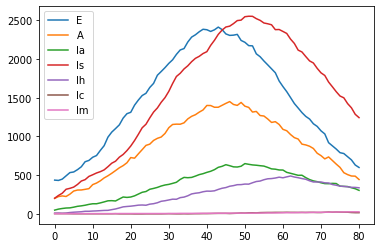

In [8]:
#np.save('post_intervention_SEAI5R_traj.npy', data['X'])

# plot the stochastic solution 
plt.plot(data['X'][:, M], label='E')
plt.plot(data['X'][:, 2*M], label='A')
plt.plot(data['X'][:, 3*M], label='Ia')
plt.plot(data['X'][:, 4*M], label='Is')
plt.plot(data['X'][:, 5*M], label='Ih')
plt.plot(data['X'][:, 6*M], label='Ic')
plt.plot(data['X'][:, 7*M], label='Im')
plt.legend()
plt.show()

In [8]:
steps =31 
estimator = pyross.inference.SEAI5R(parameters, M, fi, int(N), steps)
    
## Use inferred model parameters in the later part of the traj
params = np.load('optimal_model_param_SEAI5R.npy')
parameters = estimator.make_params_dict(params)
estimator.set_params(parameters)

## guesses and bounds for control parameters
aW_g = 0.5 
aW_std = 0.2
aW_bounds = [0.2, 0.8]

aS_g = 0.5
aS_std = 0.2 
aS_bounds = [0.2, 0.8]

aO_g = 0.4
aO_std = 0.1
aO_bounds = [0.2, 0.8]

guess = np.array([aW_g, aS_g, aO_g])
stds = np.array([aW_std, aS_std, aO_std])
bounds = np.array([aW_bounds, aS_bounds, aO_bounds])

x = (np.load('post_intervention_SEAI5R_traj.npy')[:, :8*M])/N 
# cut the trajectory 
Tf_control = 30 
Nf_control = Tf_control+1 
x = x[:Nf_control]

In [9]:
start_time = time.time() 
logp = estimator.obtain_minus_log_p(parameters, x, Tf_control, Nf_control, C)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-8773.883648924351
20.20543885231018


In [10]:
eps = 1e-3
ftol = 1e-5 
start_time = time.time() 
params_control  = estimator.infer_control(guess, stds, x, Tf_control, Nf_control, 
                                              generator, bounds,
                                              global_max_iter=5, global_ftol_factor=1e4, 
                                                verbose=True, 
                                                ftol=ftol, eps=eps)

# sometimes produce errors if input is bad, ignore and let basinhopping do its magic
end_time = time.time()
print(params_control) # best guess 
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 3 (seed=423863, Fri May  1 12:01:24 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -8.769520403497841e+03 1.0e+00 1.02e+00  7e-02  1e-01 2:52.8
    2     32 -8.777606432726127e+03 1.4e+00 1.05e+00  7e-02  9e-02 5:31.5
    3     48 -8.780091076970868e+03 1.5e+00 1.10e+00  7e-02  9e-02 8:07.4
    4     64 -8.780218083872001e+03 1.6e+00 8.72e-01  5e-02  7e-02 10:48.6
    5     80 -8.782512973980278e+03 1.8e+00 7.22e-01  3e-02  5e-02 13:36.6
Optimal value (global minimisation):  -8782.512973980278
Starting local minimisation...
Optimal value (local minimisation):  -8782.87650374231
[0.41865469 0.42131101 0.40975758]
1095.501780986786


In [11]:
# save the parameters 
#np.save('inferred_control_params_SEAI5R.npy', params_control)

[0.41865469 0.42131101 0.40975758]


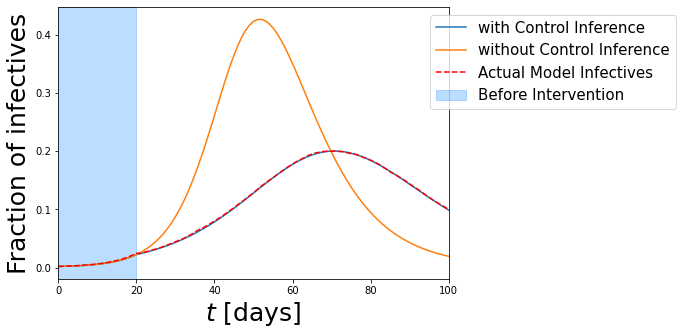

[0.41865469 0.42131101 0.40975758]


In [25]:
times = [20]

params = np.load('optimal_model_param_SEAI5R.npy')
params_control = np.load('inferred_control_params_SEAI5R.npy')
x_pre = np.load('pre_intervention_traj_SEAI5R.npy')/N
x_post = np.load('post_intervention_SEAI5R_traj.npy')/N
parameters = estimator.make_params_dict(params)
estimator.set_params(parameters)

inferred_interventions = [[1.0,1.0,1.0],      # before first time
                 params_control,       # after first time
                ]         

print(params_control)
no_interventions = [[1.0,1.0,1.0],[1.0,1.0,1.0],]

# compare the true trajectory with the 
contactMatrix_inter = generator.interventions_temporal(times=times,interventions=inferred_interventions)
contactMatrix_nointer = generator.interventions_temporal(times=times,interventions=no_interventions)

Tf=100;  Nf=Tf+1 


## create deterministic model
det_model = pyross.deterministic.SEAI5R(parameters, M, fi)
#x = data['X']/N
#x0 = x[0, :8*M]

## integrate up with the inference on control and without
x_det_control = estimator.integrate(x_pre[0], 0, Tf, Nf, det_model, contactMatrix_inter)
x_det_control= np.asarray(x_det_control)

x_det_nocontrol = estimator.integrate(x_pre[0], 0, Tf, Nf, det_model, contactMatrix_nointer)
x_det_nocontrol= np.asarray(x_det_nocontrol)


### Plotting in particular style all the infected/exposed classes A, E, and all I classes
x = np.vstack((x_pre, x_post))
## Summing all infected classes
infected_tot = np.sum(x[:,1*M:7*M], axis=1)
infected_tot_control = np.sum(x_det_control[:,1*M:7*M], axis=1)
infected_tot_nocontrol = np.sum(x_det_nocontrol[:,1*M:7*M], axis=1)

## Plotting image
ylabel=r'Fraction of infectives'
fontsize=25
fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.axvspan(0, 20, 
           label='Before Intervention',
           alpha=0.3, color='dodgerblue')

ax.plot(infected_tot_control, label='with Control Inference')
ax.plot(infected_tot_nocontrol, label='without Control Inference')
ax.plot(infected_tot, '--r', label='Actual Model Infectives')

ax.set_xlim(0,Tf)
ax.set_ylabel(ylabel,fontsize=fontsize)
ax.set_xlabel(r'$t$ [days]',fontsize=fontsize)
ax.legend(loc='upper right',bbox_to_anchor=(1.6,1),
          fontsize=15)
plt.show(fig)
print(params_control)